

Epoch:0---batch(0)训练集---ACC:3.12%---LOSS:2.423---time:128.96
Epoch:0---batch(1)训练集---ACC:28.12%---LOSS:4.922---time:109.98
Epoch:0---batch(2)训练集---ACC:21.88%---LOSS:4.895---time:110.78
Epoch:0---batch(3)训练集---ACC:28.12%---LOSS:2.813---time:111.21
Epoch:0---batch(4)训练集---ACC:25.00%---LOSS:2.674---time:110.24
Epoch:0---batch(5)训练集---ACC:31.25%---LOSS:2.460---time:111.47
Epoch:0---batch(6)训练集---ACC:37.50%---LOSS:1.701---time:111.62
Epoch:0---batch(7)训练集---ACC:34.38%---LOSS:2.700---time:111.63
Epoch:0---batch(8)训练集---ACC:56.25%---LOSS:1.513---time:111.48
Epoch:0---batch(9)训练集---ACC:46.88%---LOSS:2.047---time:110.78
Epoch:0---batch(10)训练集---ACC:50.00%---LOSS:1.818---time:109.91
Epoch:0---batch(11)训练集---ACC:62.50%---LOSS:1.251---time:115.09
Epoch:0---batch(12)训练集---ACC:53.12%---LOSS:1.341---time:111.88
Epoch:0---batch(13)训练集---ACC:78.12%---LOSS:0.849---time:112.82
Epoch:0---batch(14)训练集---ACC:78.12%---LOSS:0.658---time:112.52
Epoch:0---batch(15)训练集---ACC:78.12%---LOSS:0.608---time:111.07
E

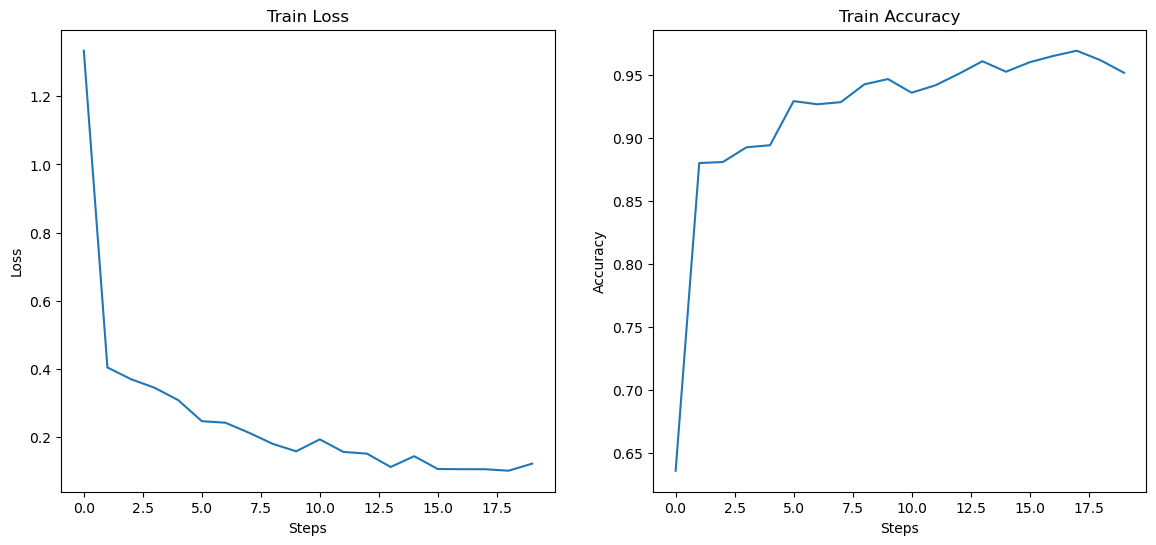

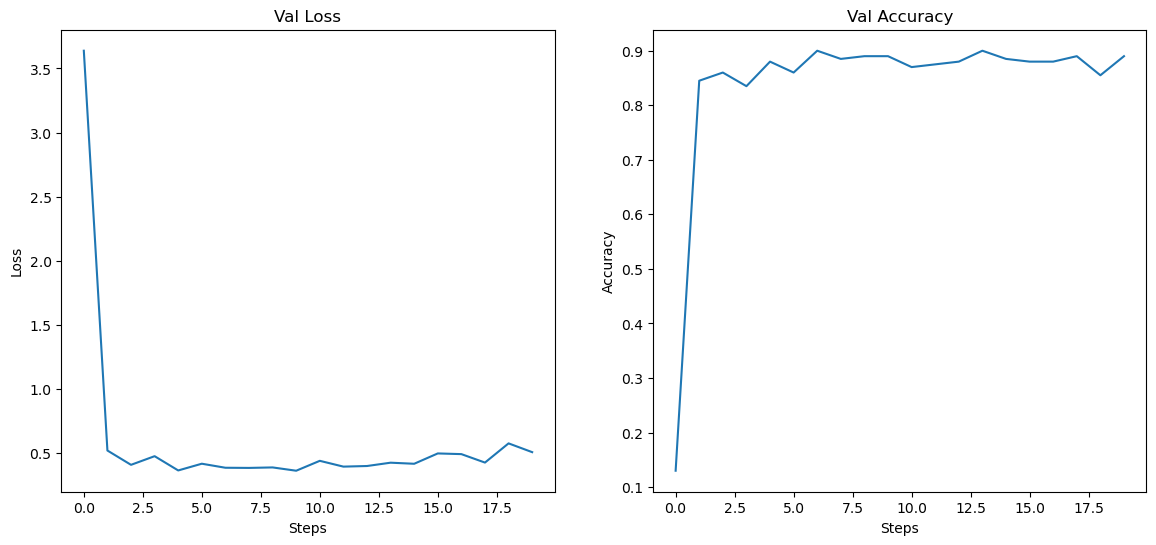

In [1]:
# %%
import tensorcircuit as tc
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split,Subset
import random
import os
import time
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import csv
import tensorflow as tf


data_path = 'C:\\Users\\17861160902_16355000\\vscode\\data'

val_num = 200
data_num =  1200           # 需要划分的数据集大小
epochs = 20                 # 迭代轮次数
batch_size = 32

# print(device)
K = tc.set_backend("tensorflow")
# 归一化处理
def trans(x):
    x = np.array(x)
    x = x/255.0
    # print(x.shape)    
    return torch.from_numpy(x).float()  # 将 NumPy 数组 x 转换为 PyTorch 张量

transform = transforms.Compose([
    transforms.Resize((14, 14)),                # 将图片缩小为 14x14
    transforms.Lambda(lambda x:trans(x))
])

# 加载MNIST数据集 28X28X1   10类别   
trainset = torchvision.datasets.MNIST(root=data_path, train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root=data_path, train=False,
                                        download=True, transform=transform)

# 随机抽取训练集 data_num 张图片作为子集
subset_indices = random.sample(range(len(trainset)), k=data_num)
train_subset = Subset(trainset, subset_indices)

# 随机抽取测试集 data_num 张图片作为子集
subset_val = random.sample(range(len(testset)), k=val_num)
val_subset = Subset(testset, subset_val)

# 加载测试集
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,shuffle=True)  # type: ignore
                                          
testloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size,shuffle=False)   # type: ignore

# %%
n = 4
nlayers = 1

# 我们定义量子函数，
# 注意这个函数是在 tensorflow 上运行的
def qpred(x, weights):
    c = tc.Circuit(n)
    for i in range(n):
        c.h(i)
        c.ry(i, theta=x[i]*weights[i])
    for j in range(nlayers):
        for i in range(n - 1):
            c.cnot(i, i + 1)
    return [K.real(c.expectation([tc.gates.z(), [i]])) for i in range(n)]

# %%
qpred_vmap = K.vmap(qpred, vectorized_argnums=0)        # `qpred_vmap` 是一个具有向量化能力的 TensorFlow 函数
qpred_batch = tc.interfaces.torch_interface(qpred_vmap, jit=True) # 我们进一步将函数包装为 PyTorch 函数

# %%
class QuantumNetV2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.q_weights = torch.nn.Parameter(torch.randn([n]))
        self.stride = 1
        self.padding_s = 3                  # 设定转置卷积的采样率 s=3

    def forward(self, inputs):

        in_bs,in_ch,in_w,in_h = inputs.shape

        kernel_size = 2

        padding_size = kernel_size - 1                  # 边界填充数
        
        # num = (in_w-1)*3+1                              # 得到插入空洞的个数 
        # 1 对输入元素间进行填充
        padding_temp = nn.functional.pad(inputs,(25,1,25,1),mode='constant',value=0)
        # print(padding_temp.shape)           # torch.Size([32, 1, 40, 40])
        
        
        # 开始元素间填充
        for bs in range(in_bs):
            for ch in range(in_ch):
                for i in range(in_w):     # 14是输入图片大小
                    for j in range(in_h):
                        padding_temp[bs,ch,i*2,j*2] = inputs[bs,ch,i,j]   # 对原图像（14X14）进行内部空洞
        # print(padding_temp)
        # print(padding_temp.shape)       # torch.Size([32, 1, 40, 40])                                                                                                                                                                                                                            

        # 2 输入特征图的周围进行边界填充， 使用转置卷积进行上采样，作为转置卷积的输入
        padd_img = nn.functional.pad(padding_temp,(padding_size,padding_size,padding_size,padding_size),mode='constant',value=0)
        # print(padd_img.shape)   # torch.Size([32, 1, 42, 42])

        bs, ch , h , w = padd_img.size()                     #    h = 42
        
        # 转置卷积后输出特征图的大小
        h_out = self.padding_s*(in_h-1)+kernel_size           #   3*（14-1）+ 2 = 41
        w_out = self.padding_s*(in_w-1)+kernel_size           #   3*（17-1）+ 2 = 41

        out = torch.zeros((bs,4, h_out, w_out))
        for b in range(bs):
                for j in range(0, h_out, self.stride):
                    for k in range(0, w_out, self.stride):

                        t1 = padd_img[b, 0, j, k]        
                        t2 = padd_img[b, 0, j, k + 1]
                        t3 = padd_img[b, 0, j + 1, k]    
                        t4 = padd_img[b, 0, j + 1, k + 1]

                        temp = torch.Tensor([t1,t2,t3,t4]) # 
                        temp = temp.view(1,4)

                        # temp = torch.unsqueeze(temp, 0)      
                        q_results = qpred_batch(temp, self.q_weights)     
                        for c in range(4):
                            out[b, c,j // kernel_size, k // kernel_size] = q_results[c]
        return out

# %%
# 经典CNNmodel 可进行修改
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
            
        # Quantum layer 1
        self.conv1 = QuantumNetV2()
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm2d(4)  # 4
        
        # Fully-Connected layer 2
        self.fc2 = nn.Linear(6724,10)
                
    def forward(self, x):

        # qconv layer 1
        out = self.conv1(x)                 
        # print(f'量子卷积之后的数据的维度{out.shape}')   #量子卷积之后的数据的维度torch.Size([64, 4, 17, 17])
        out = self.relu1(out)   
        out = self.batch1(out)
        
        #Flatten拉平操作
        out = out.view(out.size(0),-1)      # print(f'-----拉平后的维度是--{out.shape}') #  torch.Size([64, 576])
        
        #FC 第二层
        out = self.fc2(out)
        return F.log_softmax(out,dim = 1)

# %%
model = CNNModel()
loss_fun = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

# %%
# 准确率计算
def accuracy(output,labels):
    prediction = torch.max(output.data,1)[1]
    rights = prediction.eq(labels.data.view_as(prediction)).sum()
    return rights,len(labels)

# 绘制训练结果
def draw_result(accs,losses,title):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 6))   # subplots创建1行 2列的子图
    
    ax1.plot(losses) 
    ax1.set_title(title+" Loss")
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Loss")
    
    ax2.plot(accs)
    ax2.set_title(title+" Accuracy")
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Accuracy")

# %%
def train(epochs,model,loss_fun,opt,train_loader,test_loader):
    train_accuracy = []             # 训练集准确率
    train_loss = []

    val_accuracy = []               # 验证集准确率
    val_loss = []
    for epoch in range(epochs):
                ### 训练模块
        train_total_accuracy = 0    # 训练集每epoch（18个batch的和）的准确率
        train_total_loss = 0
        for batch_idx,(data,labels) in enumerate(train_loader):
            t2 = time.time()
            data = data.view(data.shape[0],1, data.shape[1], data.shape[2])
            # print(data)
            model.train()					    # 1 模型训练       
            output = model(data)			    # 2 模型输出
            # print(f'output.shape is {output.shape}')    # output.shape is torch.Size([64, 4, 17, 17])
            # print(f'labels.shape is {labels.shape}')    # labels.shape is torch.Size([64])
            loss = loss_fun(output,labels)	    # 3 计算损失

            opt.zero_grad()					    # 4 梯度清零
            loss.backward() 				    # 5 开始反向传播
            opt.step()                          # 6 梯度更新
            
            # 计算准确率
            accuracy_count, total_count = accuracy(output,labels)
            accuracy_rate = accuracy_count / total_count  # 计算准确率（预测正确的样本数除以总样本数）

            train_total_accuracy += accuracy_count
            train_total_loss +=loss.item()

            batch_time = time.time()-t2
            print(f'Epoch:{epoch}---batch({batch_idx})训练集---ACC:{accuracy_rate:.2%}---LOSS:{loss.item():.3f}---time:{batch_time:.2f}')        
        
        train_total_loss /= batch_idx+1
        train_accuracy.append(train_total_accuracy/len(train_subset))   # 保存1轮的数据 len(train_accuracy)
        train_loss.append(train_total_loss)
### 验证模块
        total_acc = 0
        total_test_loss = 0
        model.eval()
        with torch.no_grad():# 进行评测的时候网络不更新梯度
            for step,(data,target) in enumerate(test_loader):
                data = data.view(data.shape[0],1, data.shape[1], data.shape[2])            # 调整维度一致
                outputs = model(data)
                losses = loss_fun(outputs,target)                               # 计算损失

                accuracy_count, total_count = accuracy(outputs,target)          # 计算准确率
                accuracy_rate = accuracy_count / total_count                    # 计算准确率（预测正确的样本数除以总样本数）

                total_acc += accuracy_count
                total_test_loss+=losses.item()

        total_test_loss /= step + 1
        val_accuracy.append((total_acc/len(val_subset)))
        val_loss.append(total_test_loss)
        print(f'第{epoch}轮测试集准确率：{total_acc/len(val_subset):.2%}....测试集Loss:{total_test_loss}')
    
    ### 画出训练结果图 ##############
    draw_result(train_accuracy,train_loss,"Train")
    draw_result(val_accuracy,val_loss,"Val")
    
    ####  训练的结果写入文件   ##############
    with open(str(random.randint(100,999))+"_train.csv",mode='w',newline='') as file:         # newline='' 指定行与行之间的分隔符，每一行都将以换行符（'\n'）作为分隔符
        wirter = csv.writer(file)                               # 以视图模式打开csv文件
        wirter.writerow(['Epoch','Train_loss','Train_acc'])     # 将一行数据写入csv文件中，这里写入标题行
        for i in range(epochs):                                 # 写入数据行
            wirter.writerow([i, train_loss[i], train_accuracy[i].numpy()])
    
    #### 测试的结果写入文件  ##############
    with open(str(random.randint(1000,9999))+"_val.csv",mode='w',newline='') as file:         # newline='' 指定行与行之间的分隔符，每一行都将以换行符（'\n'）作为分隔符
        wirter = csv.writer(file)                               # 以视图模式打开csv文件
        wirter.writerow(['Epoch','Val_loss','Val_acc'])     # 将一行数据写入csv文件中，这里写入标题行
        for i in range(epochs):                                 # 写入数据行
            wirter.writerow([i, val_loss[i], val_accuracy[i].numpy()])

    ### 保存训练的结果
    # Loss0 = torch.tensor(save_train_loss)
    # torch.save(Loss0,'E:\\Test\\VsCode_Test\\Python\\xlw\\test1\\lw2\\epoch_{}'.format(epochs))
    return model, train_accuracy,train_loss


model, train_accuracy,train_loss = train(epochs,model,loss_fun,opt,trainloader,testloader)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 经典与传统的对比
# 加载经典
# Classical_Train_data = pd.read_csv('/home/WUYING_986418966_1288354473/Desktop/QCNN/src/QCNN-FC/QTCNN-MNIST/640_train.csv')
# Classical_Val_data = pd.read_csv('/home/WUYING_986418966_1288354473/Desktop/QCNN/src/QCNN-FC/QTCNN-MNIST/2091_val.csv')

# Classical_Train_data_acc = Classical_Train_data[['Train_acc']]
# Classical_Train_data_loss = Classical_Train_data[['Train_loss']]

# Classical_Val_data_acc = Classical_Val_data[['Val_acc']]
# Classical_Val_data_loss = Classical_Val_data[['Val_loss']]
def result(acc,loss,plt1_title,plt2_title,title):     # 合并结果
    #绘图
    plt.xticks(np.arange(0,20,1))
    plt.plot(acc,label=plt1_title)
    plt.plot(loss,label=plt2_title)
    plt.title(title) 
    plt.xlabel('epoch')
    plt.ylabel('probability')
    plt.legend()   #显示标签
    plt.show()

# 加载qcnn
Qcnn_Train_data = pd.read_csv('C:\\Users\\17861160902_16355000\\vscode\MNIST\\s=3\\433_train.csv')
Qcnn_Val_data = pd.read_csv('C:\\Users\\17861160902_16355000\\vscode\MNIST\\s=3\\2372_val.csv')

Qcnn_Train_data_acc = Qcnn_Train_data[['Train_acc']]
Qcnn_Train_data_loss = Qcnn_Train_data[['Train_loss']]

Qcnn_Val_data_acc = Qcnn_Val_data[['Val_acc']]
Qcnn_Val_data_loss = Qcnn_Val_data[['Val_loss']]

# 损失值比较
result(Qcnn_Train_data_loss,Qcnn_Val_data_loss,'Train_set','Val_set','Loss')
# 准确率比较
result(Qcnn_Train_data_acc,Qcnn_Val_data_acc,'Train_set','Val_set','ACC')